In [19]:
# Tratamiento de datos
import pandas as pd
import numpy as np


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns


# Modelos
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from pmdarima import ARIMA



import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'sktime'

In [8]:
# Especifica la ruta relativa al archivo CSV
file_path = '../data/raw/tudato.csv'  # Subiendo un nivel desde la carpeta notebooks

# Lee el archivo CSV en un DataFrame
data_nolog = pd.read_csv(file_path)

In [31]:
# Lee el archivo CSV en un DataFrame
data = pd.read_csv(r'C:\Users\laura\OneDrive\Desktop\PROYECTO ML\ml_project\src\data\processed\df_log_sdt.csv')

In [32]:
df = data.copy()

In [34]:
df['datetime'] = data_nolog['datetime']

In [35]:
df

,Unnamed: 0,GHI,Festivo,Gas,PotenciaViento,Ano,Mes,Dia,Hora,GMT,datetime
0,0,1.381021,0.327312,2.085768,-0.442553,1.201122,1.071088,0.374221,0.213776,0.827616,2016-01-01 00:00:00
1,1,-0.549200,-0.212752,-0.678462,-0.442553,-1.505081,1.071088,-1.446692,-0.509300,0.827616,2016-01-01 01:00:00
2,2,1.371064,-0.094189,-2.149143,-0.442553,0.750088,-0.979795,0.943257,0.503007,-1.208289,2016-01-01 02:00:00
3,3,-1.349031,0.118930,-2.590410,-0.442553,1.652156,-0.686812,-0.991464,-0.653915,0.827616,2016-01-01 03:00:00
4,4,0.291861,-0.247504,0.441495,-0.442553,-1.505081,-0.979795,0.032800,1.081467,-1.208289,2016-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
53696,53696,0.624034,-0.999588,0.909111,2.259614,0.299054,-0.979795,1.512292,1.081467,0.827616,2022-02-15 08:00:00
53697,53697,-0.067178,-0.202953,0.183461,2.259614,-1.505081,0.778104,0.260414,-1.376991,0.827616,2022-02-15 09:00:00
53698,53698,-1.627827,1.633095,0.206974,-0.442553,1.201122,-0.686812,-1.219078,1.659928,0.827616,2022-02-15 10:00:00
53699,53699,-0.802948,-0.244513,-0.011761,-0.442553,-1.505081,-1.272779,-1.219078,1.226083,-1.208289,2022-02-15 11:00:00


In [36]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [45]:
df.columns

Index(['GHI', 'Festivo', 'Gas', 'PotenciaViento', 'year', 'month', 'day',
       'hour', 'GMT'],
      dtype='object')

**CUADRO DEFINICIÓN VARIABLES**

|Columna| Descripción | 
|---|----|
|GHI| irradiancia global horizontal/ Potencia fotovoltaica| 
|Gas| precio del gas en el momento de la medición| 
|Festivo| Booleano indicando si el dia del registro era o no domingo/festivo (influye en el precio de la energía)| 
|PotenciaViento| Watios potencia generados por energía eólica| 
|Precios| TARGET - Precio de la energía | 
|Ano| Año del registro| 
|Mes| Mes del registro| 
|Dia| Día del registro| 
|Hora| hora del registro| 
|GMT| zona horaria| 

In [37]:
new_col = {'Ano': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour'}
df.rename(columns=new_col, inplace=True)
# data_nolog['datetime'] = pd.to_datetime(data_nolog[['year', 'month','day', 'hour']])
# df = df.drop(columns=['year', 'month', 'day', 'hour'])


In [38]:
df.set_index('datetime', inplace=True)

In [41]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [42]:
columnas_log = ['GHI', 'Gas', 'PotenciaViento']


pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('log', FunctionTransformer(np.log1p, validate=True), columnas_log)  # Aplica logaritmo
        ],
        remainder='passthrough'  # Mantén las columnas no especificadas
    ),
    StandardScaler()  # Estandarizar todo el DataFrame
)

# Aplica el pipeline al DataFrame
df_log_estandarizado = pipeline.fit_transform(df)

In [39]:
# Drop duplicate index labels
df = df[~df.index.duplicated()]

# Now, reindex with hourly frequency
df = df.asfreq('h')
df.rename(columns={0: 'values'}, inplace=True)
df.fillna(0, inplace=True)

**VARIABLES EXOGENAS**

In [50]:
df_log_estandarizado = pd.DataFrame(df_log_estandarizado)

In [54]:
df_log_estandarizado = df_log_estandarizado.assign(precios=data_nolog['Precios'], datetime=data_nolog['datetime'])


In [57]:
df_log_estandarizado.set_index('datetime', inplace=True)


In [21]:
from sktime.forecasting.model_selection import temporal_train_test_split


In [58]:
x_train, x_test = temporal_train_test_split(df_log_estandarizado, test_size=6712)

In [62]:
columns = {0: 'GHI', 1: 'Festivo', 2: 'Gas', 3: 'PotenciaViento'}

In [67]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 2, 1, 12),
                                maxiter=200
                            )
             )

forecaster.fit(
    y                 = x_train['precios'], 
    exog              = x_train[[0, 1, 2, 3]],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 200,
                  exog  = x_test[[0, 1, 2, 3]]
              )
predictions.head(3)

MissingDataError: exog contains inf or nans

los resultados de justo arriba son con order 121. pero daban muy mal msse 115

In [66]:
# ======================================================================================
error_mse = mean_absolute_error(
                y_true = x_test['Precios'].head(200),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

# exogen3

Test error (mse): 37.429744773866766


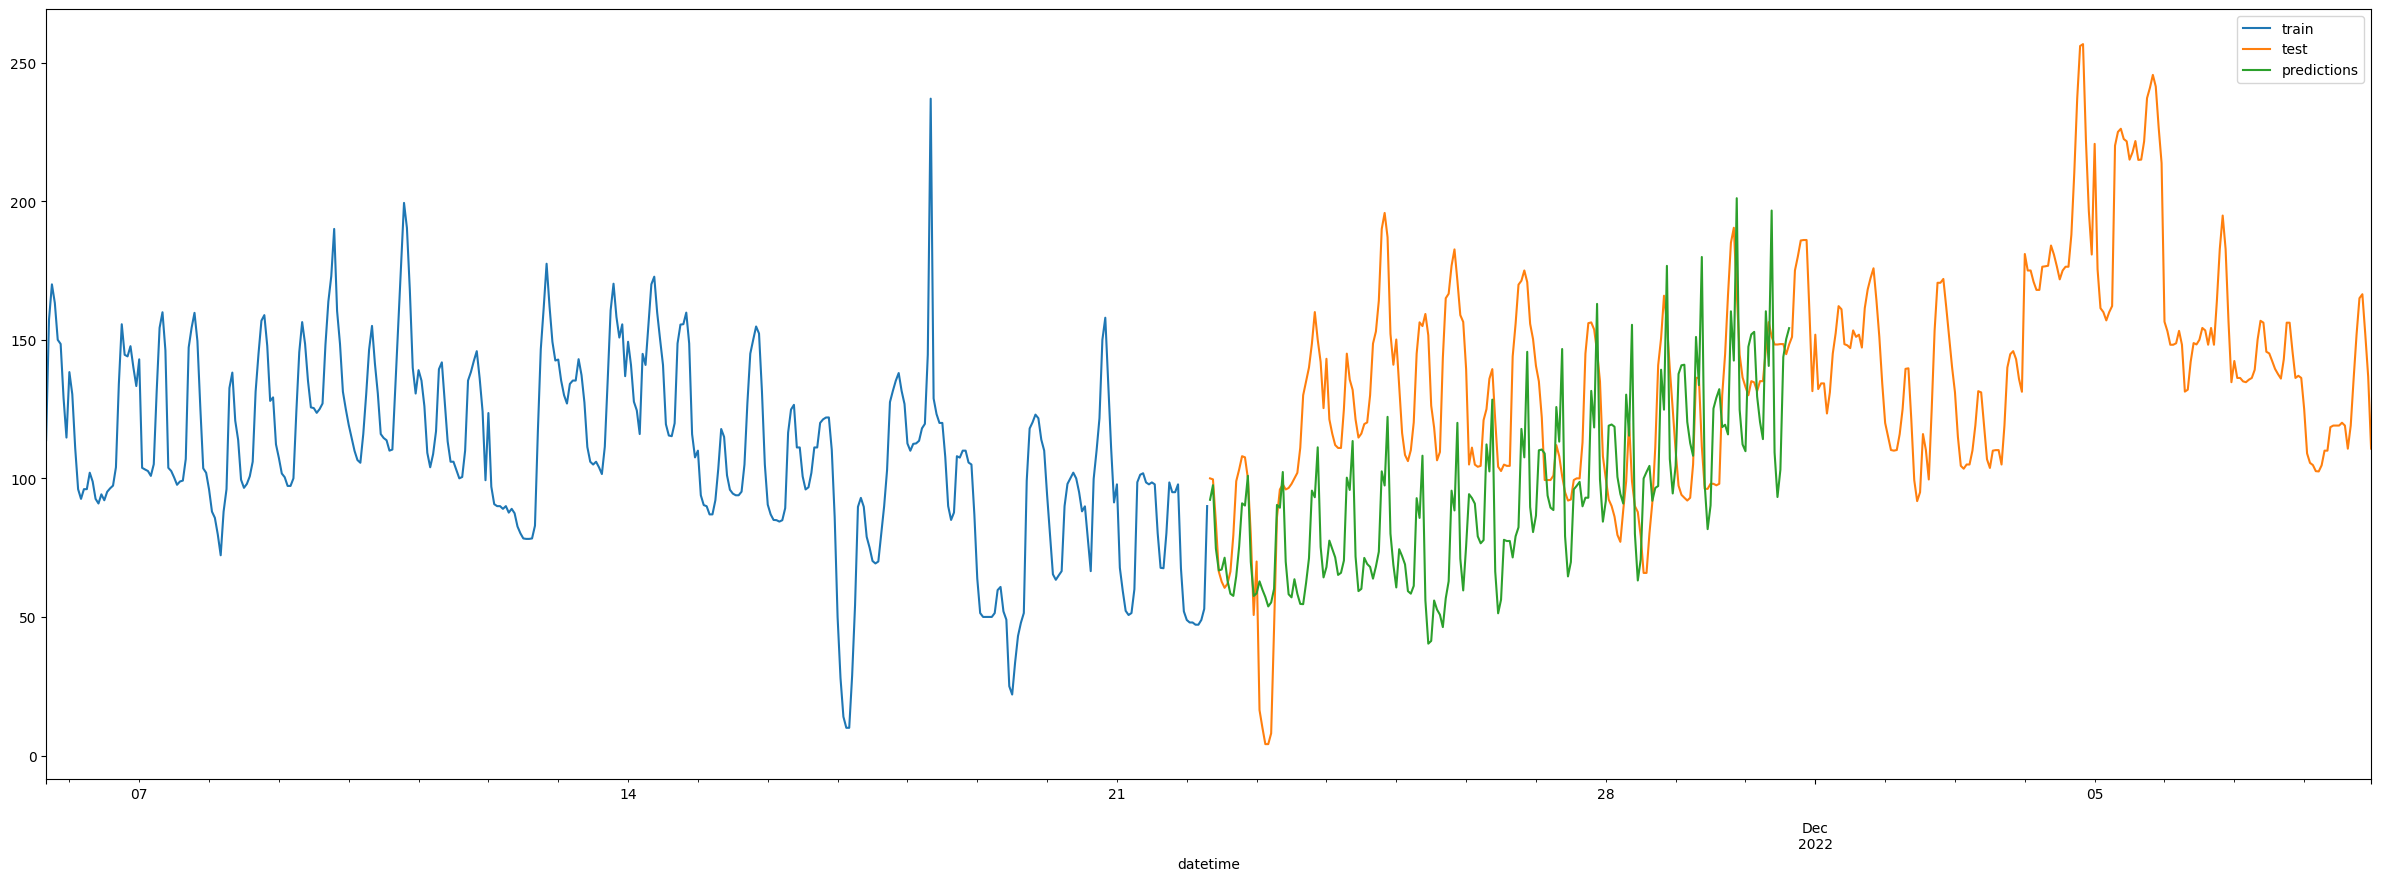

In [65]:
fig, ax = plt.subplots(figsize=(30, 10
                                ))
x_train['Precios'].tail(400).plot(ax=ax, label='train')
x_test['Precios'].head(400).plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
# exogen3

In [74]:
# Predict intervals
# # ======================================================================================
predictions_interval = forecaster.predict_interval(steps=36,exog  = x_test[['GHI', 'Festivo', 'Gas', 'PotenciaViento']], interval=[5, 95])
predictions_interval.head(3)
# exogen3

,pred,lower_bound,upper_bound
2022-11-22 08:00:00,92.267002,60.561851,123.972154
2022-11-22 09:00:00,97.540109,47.580535,147.499684
2022-11-22 10:00:00,74.722992,9.929430,139.516554


In [67]:
dump(forecaster, 'exogen_model3.joblib')

['exogen_model3.joblib']

### MODELO CON SERIES DIFERENCIADAS

In [28]:
# Modificar el modelo SARIMAX para trabajar con la serie diferenciada
forecaster_dif = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(0, 2, 1),  # Modificar el orden para reflejar la diferenciación de orden 2
                                seasonal_order=(1, 2, 1, 12),
                                maxiter=200
                            )
             )
exog = x_train[['GHI', 'Festivo', 'Gas', 'PotenciaViento']].iloc[2:]
# Reentrenar el modelo con la serie temporal diferenciada
forecaster_dif.fit(
    y                 = x_train['Precios'].diff().diff().dropna(),  # Utilizar la serie temporal diferenciada de orden 2
    exog              = exog,
    suppress_warnings = True
)

# Predecir con la serie temporal diferenciada
predictions_dif = forecaster_dif.predict(
                  steps = 200,
                  exog  = x_test[['GHI', 'Festivo', 'Gas', 'PotenciaViento']]
              )
predictions_dif.head(3)


2022-11-22 08:00:00    18.569180
2022-11-22 09:00:00    34.337537
2022-11-22 10:00:00    16.175621
Freq: H, Name: pred, dtype: float64

In [29]:
# ======================================================================================
error_mse = mean_absolute_error(
                y_true = x_test['Precios'].head(200),
                y_pred = predictions_dif
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 117.05942649538507


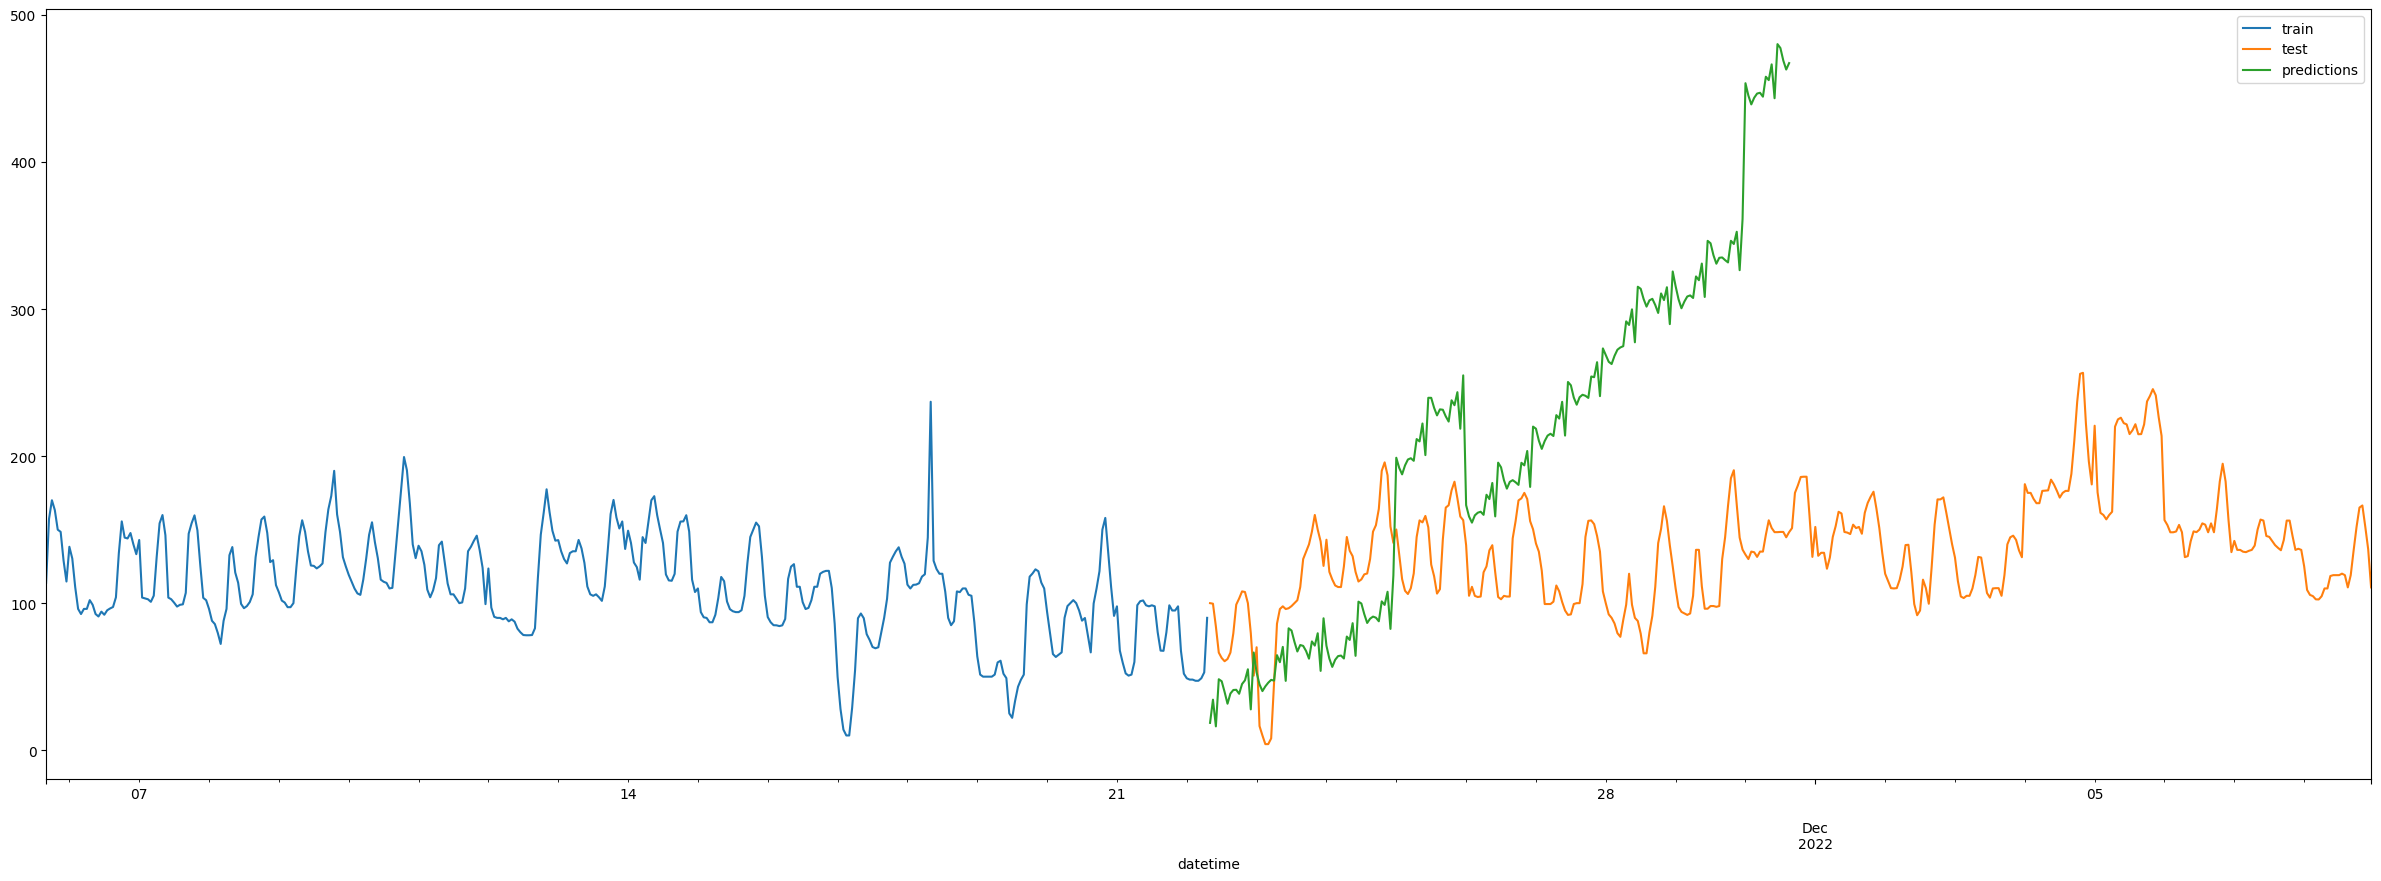

In [30]:
# Visualización de las predicciones

fig, ax = plt.subplots(figsize=(30, 10
                                ))
x_train['Precios'].tail(400).plot(ax=ax, label='train')
x_test['Precios'].head(400).plot(ax=ax, label='test')
predictions_dif.plot(ax=ax, label='predictions')
ax.legend();

## OTROS MODELOS ##

In [62]:
pd.DataFrame(predictions)
# exogen2 (es el guardado en joblib)

,pred
2022-02-15 15:00:00,157.961178
2022-02-15 16:00:00,162.882230
2022-02-15 17:00:00,192.029314
2022-02-15 18:00:00,221.483374
2022-02-15 19:00:00,248.926991
...,...
2022-02-23 18:00:00,216.567028
2022-02-23 19:00:00,251.456593
2022-02-23 20:00:00,249.359167
2022-02-23 21:00:00,240.739379


In [52]:
# ======================================================================================
error_mse = mean_absolute_error(
                y_true = x_test['Precios'].head(200),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
# exogen2 (es el guardado en joblib)

Test error (mse): 32.10021039482279


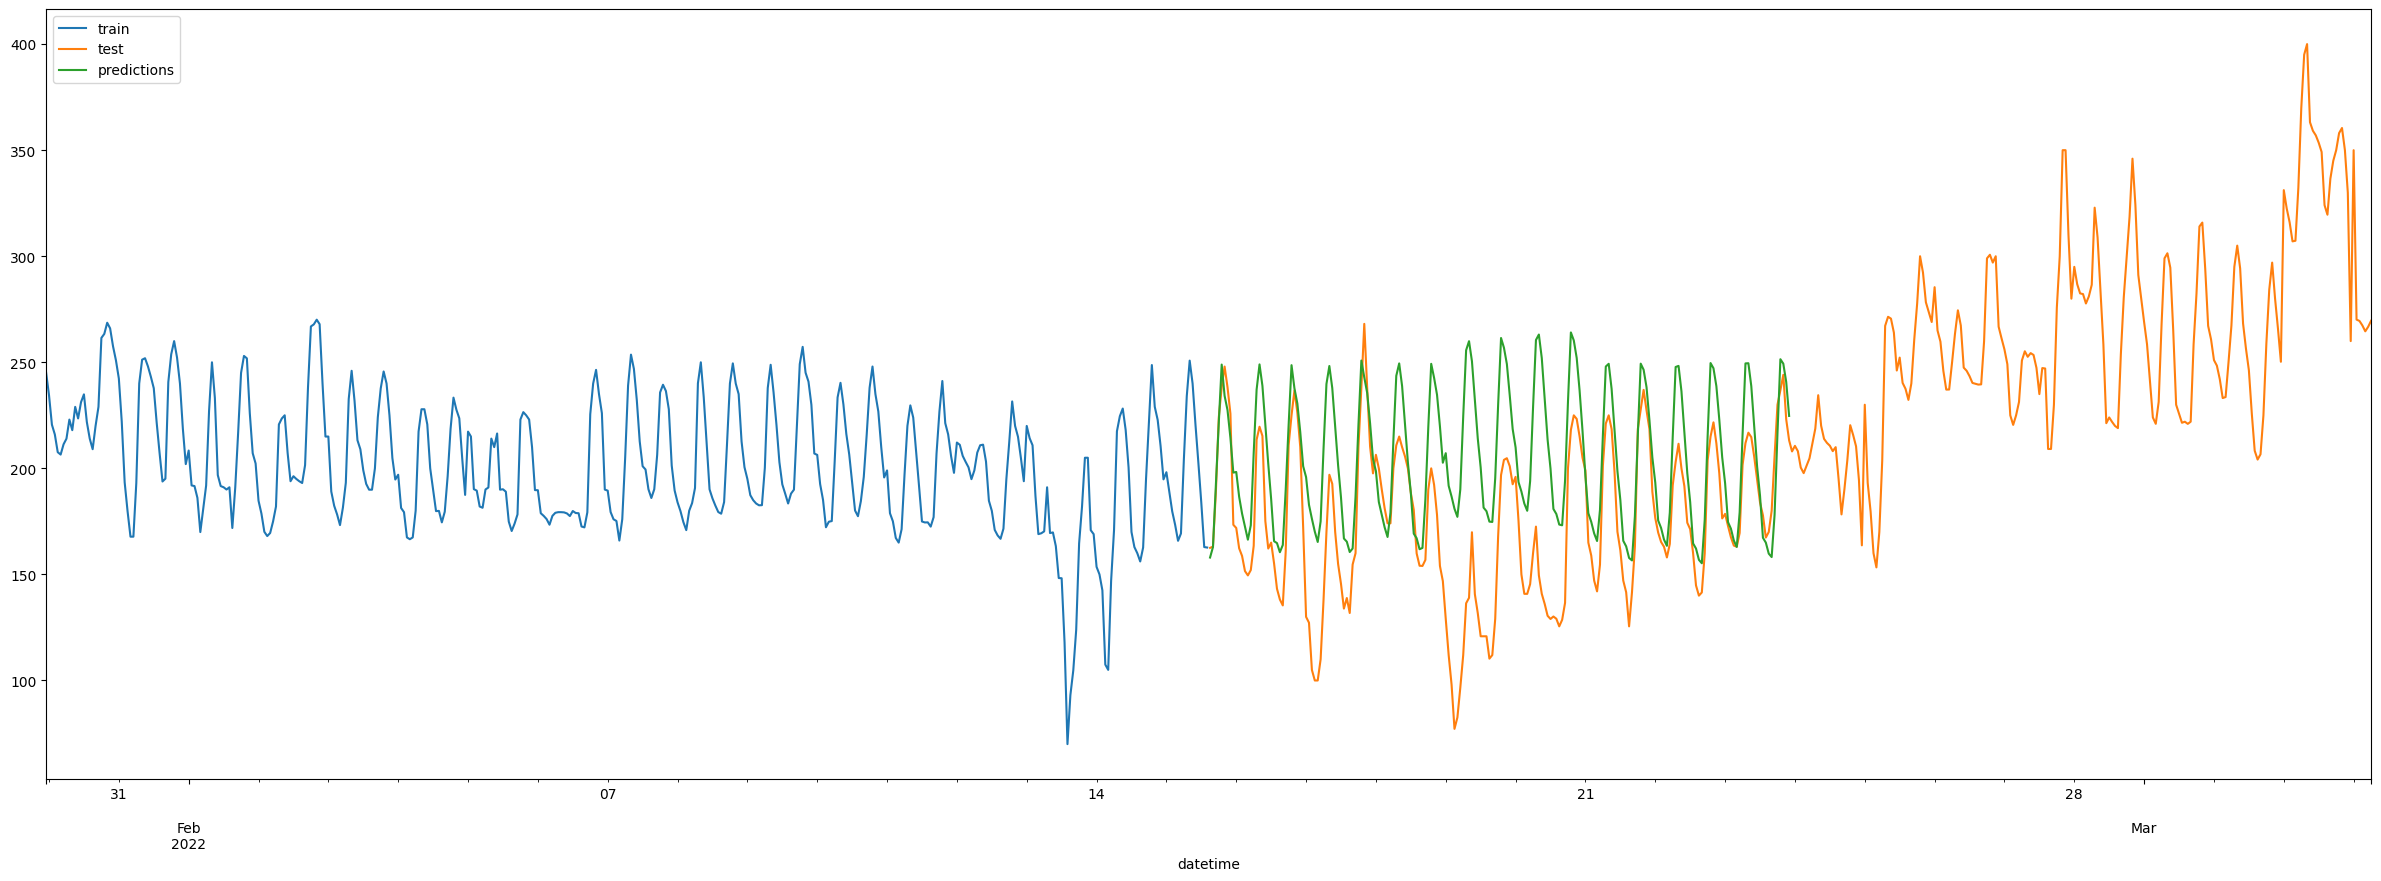

In [53]:
fig, ax = plt.subplots(figsize=(30, 10
                                ))
x_train['Precios'].tail(400).plot(ax=ax, label='train')
x_test['Precios'].head(400).plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# exogen2 (es el guardado en joblib)

In [56]:

from joblib import dump, load
import statsmodels.api as sm

dump(forecaster, 'exogen_model.joblib')

['exogen_model.joblib']

In [55]:
import pickle

# Cargar el modelo desde el archivo pickle
with open(r'C:\Users\laura\OneDrive\Desktop\PROYECTO ML\ml_project\src\models\ignore\exogen_model2.pkl', 'rb') as archivo:
    forecaster_cargado = pickle.load(archivo)

**MODELO CON V. EXOGENAS 1**

In [ ]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 2, 1),
                                seasonal_order=(1, 2, 1, 12),
                                maxiter=200
                            )
             )

forecaster.fit(
    y                 = x_train['Precios'], 
    exog              = x_train[['GHI', 'Festivo', 'Gas', 'PotenciaViento']],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 200,
                  exog  = x_test[['GHI', 'Festivo', 'Gas', 'PotenciaViento']]
              )
predictions.head(3)

In [49]:
# ======================================================================================
error_mse = mean_absolute_error(
                y_true = x_test['Precios'].head(36),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

# error de exogen1, pero tenia muy pocas predicciones

Test error (mse): 22.67692862377028


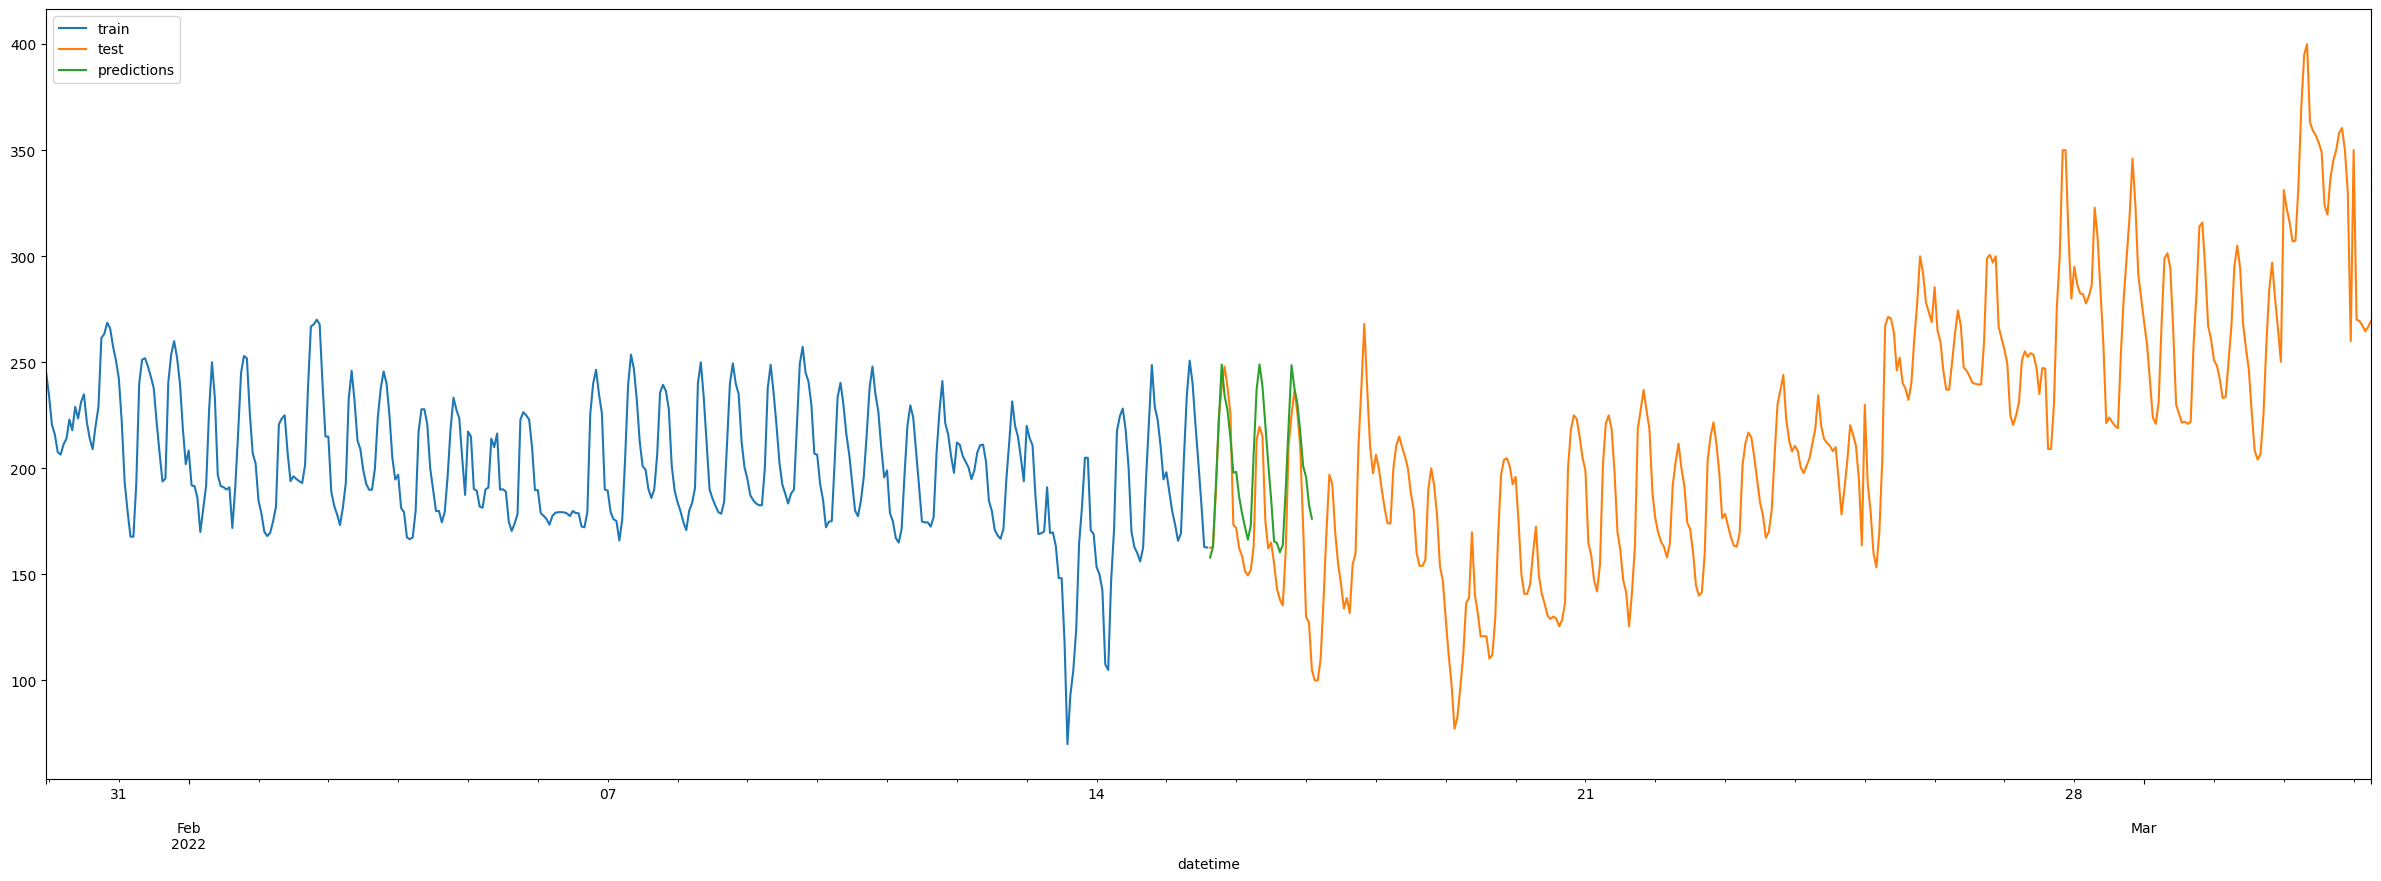

In [48]:
# Gráfico de predicciones vs valores reales EXOGEN 1
# ==============================================================================
fig, ax = plt.subplots(figsize=(30, 10
                                ))
x_train['Precios'].tail(400).plot(ax=ax, label='train')
x_test['Precios'].head(400).plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Exportar modelo

In [46]:
import pickle
with open('exogen_model.pkl', 'wb') as f:
    pickle.dump(forecaster, f)

In [20]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )

param_grid = {
    'order': [(2, 1, 0), (5, 1, 1), (8, 1, 4)],
    'seasonal_order': [(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster         = forecaster,
                   y                  = df2_df['values'],
                   param_grid         = param_grid,
                   steps              = 168,
                   refit              = True,
                   metric             = 'mean_absolute_error',
                   initial_train_size = len(df2_train),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = True,
                   show_progress      = True
               )

results_grid.head(5)

Number of models compared: 9.


params grid:   0%|          | 0/9 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 61345
Number of observations used for backtesting: 5783
    Number of folds: 35
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 71 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2022-12-31 00:00:00  (n=61345)
    Validation: 2022-12-31 01:00:00 -- 2023-01-07 00:00:00  (n=168)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2023-01-07 00:00:00  (n=61513)
    Validation: 2023-01-07 01:00:00 -- 2023-01-14 00:00:00  (n=168)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2023-01-14 00:00:00  (n=61681)
    Validation: 2023-01-14 01:00:00 -- 2023-01-21 00:00:00  (n=168)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2023-01-21 00:00:00  (n=61849)
    Validation: 2023-01-21 01:00:00 -- 2023-01-28 00:00:00  (n=168)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2023-0

params grid:  11%|█         | 1/9 [00:37<05:00, 37.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 61345
Number of observations used for backtesting: 5783
    Number of folds: 35
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 71 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2022-12-31 00:00:00  (n=61345)
    Validation: 2022-12-31 01:00:00 -- 2023-01-07 00:00:00  (n=168)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2023-01-07 00:00:00  (n=61513)
    Validation: 2023-01-07 01:00:00 -- 2023-01-14 00:00:00  (n=168)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2023-01-14 00:00:00  (n=61681)
    Validation: 2023-01-14 01:00:00 -- 2023-01-21 00:00:00  (n=168)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2023-01-21 00:00:00  (n=61849)
    Validation: 2023-01-21 01:00:00 -- 2023-01-28 00:00:00  (n=168)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2023-0

params grid:  22%|██▏       | 2/9 [01:15<04:22, 37.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 61345
Number of observations used for backtesting: 5783
    Number of folds: 35
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 71 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2022-12-31 00:00:00  (n=61345)
    Validation: 2022-12-31 01:00:00 -- 2023-01-07 00:00:00  (n=168)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2023-01-07 00:00:00  (n=61513)
    Validation: 2023-01-07 01:00:00 -- 2023-01-14 00:00:00  (n=168)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2023-01-14 00:00:00  (n=61681)
    Validation: 2023-01-14 01:00:00 -- 2023-01-21 00:00:00  (n=168)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2023-01-21 00:00:00  (n=61849)
    Validation: 2023-01-21 01:00:00 -- 2023-01-28 00:00:00  (n=168)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2023-0

params grid:  33%|███▎      | 3/9 [02:30<05:28, 54.71s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 61345
Number of observations used for backtesting: 5783
    Number of folds: 35
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 71 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2022-12-31 00:00:00  (n=61345)
    Validation: 2022-12-31 01:00:00 -- 2023-01-07 00:00:00  (n=168)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2023-01-07 00:00:00  (n=61513)
    Validation: 2023-01-07 01:00:00 -- 2023-01-14 00:00:00  (n=168)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2023-01-14 00:00:00  (n=61681)
    Validation: 2023-01-14 01:00:00 -- 2023-01-21 00:00:00  (n=168)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2023-01-21 00:00:00  (n=61849)
    Validation: 2023-01-21 01:00:00 -- 2023-01-28 00:00:00  (n=168)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2023-0

params grid:  33%|███▎      | 3/9 [04:29<08:58, 89.81s/it]


KeyboardInterrupt: 